In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import random

from bandit import BernoulliBandit
from helper import random_argmax, run_algorithm, plot_regret_single, plot_arm_choices, plot_ucb, plot_beta_distribution, plot_thompson, plot_regret_double, plot_regret_triple

In [2]:
random.seed(59)
np.random.seed(59)

# Simulated Bernoulli Bandit Demonstration

Consider a Bernoulli bandit with 5 arms.
Each arm has a probability p_i to grant reward of 1, otherwise 0. 

In [3]:
mab_main = BernoulliBandit(horizon=2000, num_arms=5, prob_min=0, prob_max=1)

#real arm reward(our algorithm won't know this)
print(mab_main.success_probs)

[0.92403512 0.15787058 0.86691508 0.08415694 0.57357368]


Notice that arm 2 and arm 4 have very similar true mean -- it will be challenging for our algorithms to discern this.

## 1. Pure Exploration Strategy
Two common ways to implement this
1.1 pick completely at random
1.2 pick whichever arm has been tried the fewest times

In [4]:
class Explore:
    def __init__(self, bandit):
        self.bandit = bandit

    def reset(self):
        self.bandit.reset()

    def play_one_step(self):
        """
        Pulls an arm that has been pulled the least so far.
        If multiple arms are tied, one is chosen randomly.
        """
        pulls = self.bandit.arm_pull_counts
        least_pulled_arms = np.where(pulls == pulls.min())[0]
        chosen_arm = np.random.choice(least_pulled_arms)
        return self.bandit.pull_arm(chosen_arm)

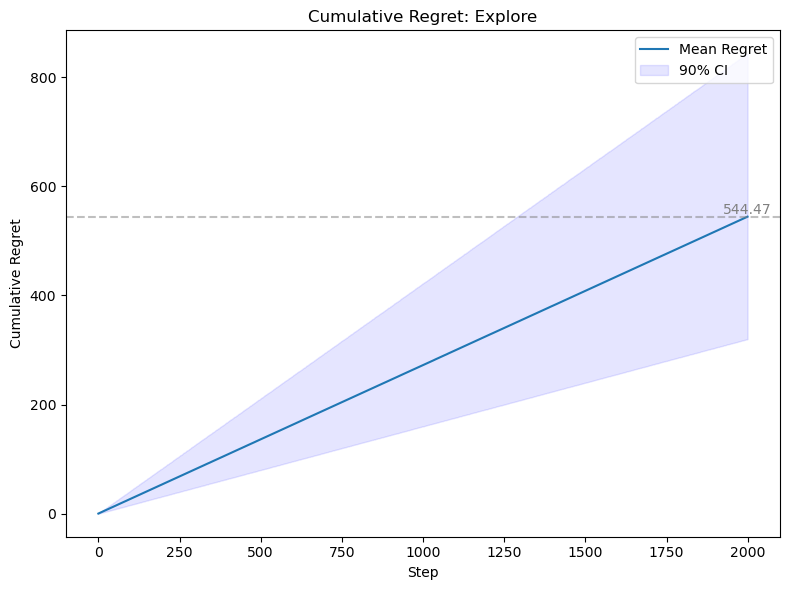

In [5]:
mab = copy.deepcopy(mab_main)
alg = Explore(mab)
regretls = run_algorithm(mab, alg, R=100)
plot_regret_single(mab, regretls, 'Explore')

In pure exploration, every arm is sampled almost equally

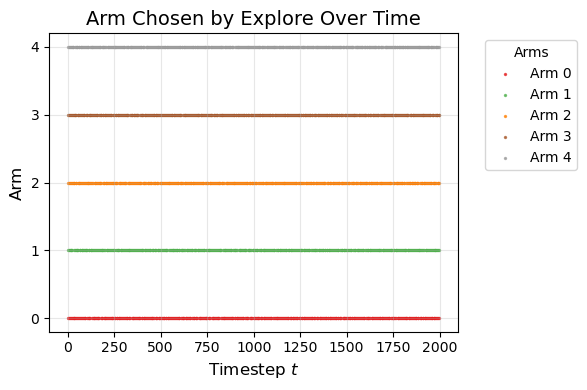

In [6]:
plot_arm_choices(alg.bandit.horizon, alg.bandit.arm_history, 'Explore')

## 2. Pure Greedy Strategy
Try each arm once, then commit to best arm

In [7]:
class Greedy:
    def __init__(self, bandit):
        self.bandit = bandit

    def reset(self):
        self.bandit.reset()

    def play_one_step(self):
        """
        Pulls an arm based on the greedy algorithm:
        - Explore: If there are unpulled arms, pull one at random.
        - Exploit: Otherwise, pull the arm with the highest average reward.
        """
        pulls = self.bandit.arm_pull_counts
        total_rewards = self.bandit.total_rewards

        if np.any(pulls == 0):
            # Explore: Pull an unpulled arm
            unpulled_arms = np.where(pulls == 0)[0]
            chosen_arm = np.random.choice(unpulled_arms)
        else:
            # Exploit: Pull the arm with the highest average reward
            avg_rewards = np.divide(total_rewards, pulls, where=pulls != 0)
            chosen_arm = random_argmax(avg_rewards)

        return self.bandit.pull_arm(chosen_arm)

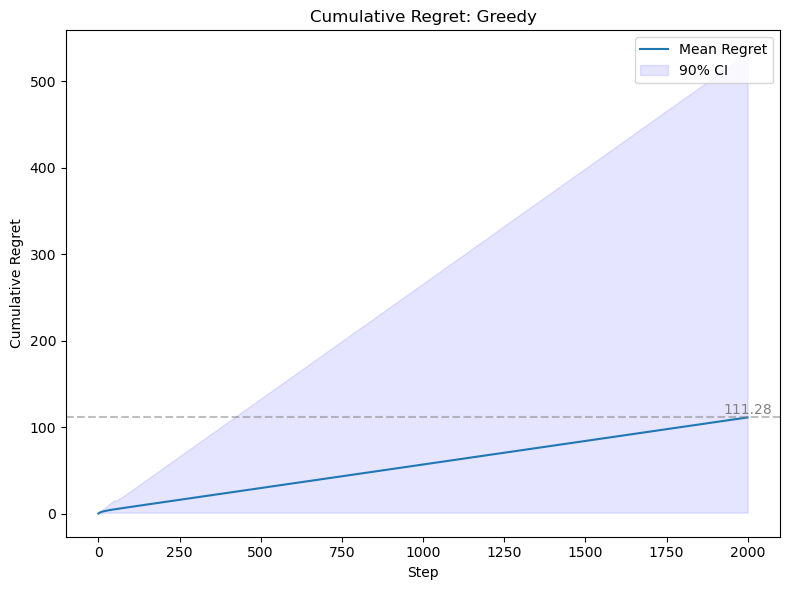

In [8]:
mab = copy.deepcopy(mab_main)
alg = Greedy(mab)
regretls = run_algorithm(mab, alg, R=100)
plot_regret_single(mab, regretls, 'Greedy')

Notice that the algorithm tries each arm once, then just commit to arm 0.

During the commit phase, the optimal arm can change because we are still updating that arm mean estimate. 

[0.92403512 0.15787058 0.86691508 0.08415694 0.57357368]


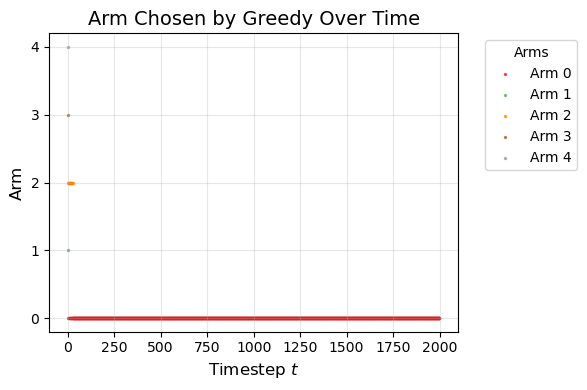

In [9]:
mab = copy.deepcopy(mab_main)
alg = Greedy(mab)
regretls = run_algorithm(mab, alg, R=1)
print(mab.success_probs )
plot_arm_choices(alg.bandit.horizon, alg.bandit.arm_history, 'Greedy')

## 3. Explore then commit
Try each arm Ne times, then commit to best arm

In [10]:
class ExploreThenCommit:
    def __init__(self, bandit, Ne):
        """
        Initializes the ExploreThenCommit algorithm.
        
        Args:
        - bandit: The bandit instance to interact with.
        - Ne: Minimum number of exploration pulls required for each arm.
        """
        self.bandit = bandit
        self.Ne = Ne
        self.best_arm = None  # Tracks the arm to commit to once exploration is complete

    def reset(self):
        """Resets the bandit and algorithm state."""
        self.bandit.reset()
        self.best_arm = None

    def play_one_step(self):
        """
        Executes one step of the Explore-Then-Commit strategy:
        - Pulls a random arm if there are arms with fewer than Ne pulls.
        - Otherwise, pulls the arm with the highest average reward.
        """
        pulls = self.bandit.arm_pull_counts

        # Explore: Pull a random arm if any arm has fewer than Ne pulls
        if np.any(pulls < self.Ne):
            unpulled_arms = np.where(pulls < self.Ne)[0]
            chosen_arm = np.random.choice(unpulled_arms)
        else:
            # Commit: Pull the arm with the highest average reward
            if self.best_arm is None:
                avg_rewards = np.divide(
                    self.bandit.total_rewards, 
                    pulls, 
                    where=pulls != 0
                )
                self.best_arm = np.argmax(avg_rewards)
            chosen_arm = self.best_arm

        return self.bandit.pull_arm(chosen_arm)


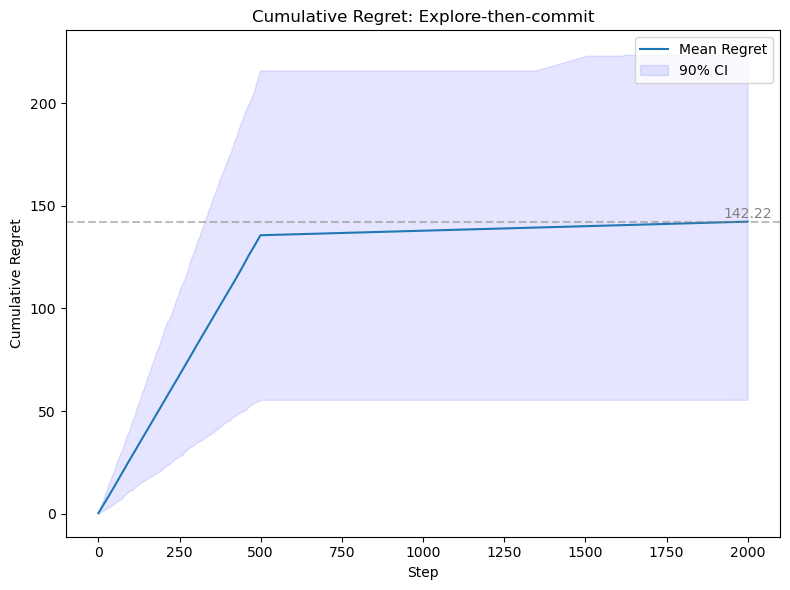

In [11]:
mab = copy.deepcopy(mab_main)
alg = ExploreThenCommit(mab, Ne = 100)
regretls = run_algorithm(mab, alg, R=100)
plot_regret_single(mab, regretls, 'Explore-then-commit')

[0.92403512 0.15787058 0.86691508 0.08415694 0.57357368]


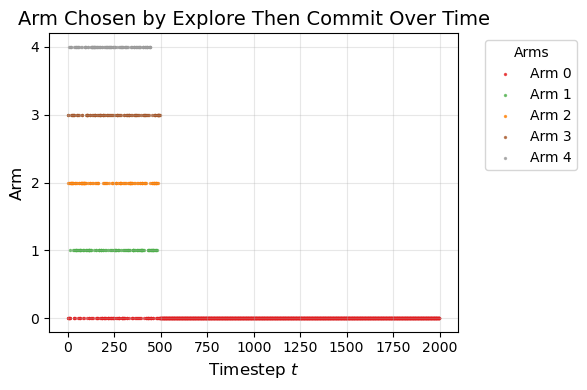

In [12]:
mab = copy.deepcopy(mab_main)
alg = ExploreThenCommit(mab, Ne = 100)
regretls = run_algorithm(mab, alg, R=1)
print(mab.success_probs )
plot_arm_choices(alg.bandit.horizon, alg.bandit.arm_history, 'Explore Then Commit')

Arm 0 was commited after exploration! This is actually correct.

## 4. Epsilon-Greedy
With probability epsilon, explore. Otherwise choose arm with highest mean estimate(exploit).

In [13]:
class EpsilonGreedy:
    def __init__(self, bandit, epsilon=0.1, auto_update = False):
        self.bandit = bandit
        self.epsilon = epsilon
        self.auto_update = auto_update

    def reset(self):
        self.bandit.reset()

    def play_one_step(self):
        """
        Implements the Epsilon-Greedy strategy:
        - With probability `epsilon`, explore (choose a random arm).
        - Otherwise, exploit (choose the arm with the highest average reward).
        """
        pulls = self.bandit.arm_pull_counts
        total_rewards = self.bandit.total_rewards
        K = self.bandit.num_arms
        t = len(self.bandit.reward_history)

        if(self.auto_update):
            self.epsilon = (K*np.log(t)/t)**(1/3)

        if np.random.uniform(0, 1) < self.epsilon:
            # Explore: Pull a random arm
            chosen_arm = np.random.choice(self.bandit.num_arms)
        else:
            # Exploit: Pull the arm with the highest average reward
            avg_rewards = np.divide(total_rewards, pulls, where=pulls != 0)
            chosen_arm = random_argmax(avg_rewards)

        return self.bandit.pull_arm(chosen_arm)

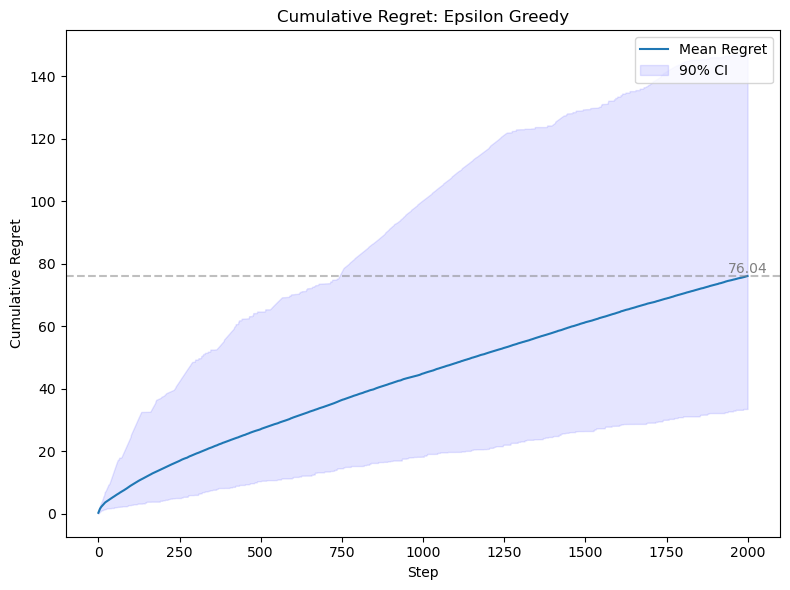

In [14]:
mab = copy.deepcopy(mab_main)
alg = EpsilonGreedy(mab, epsilon = 0.1)
regretls = run_algorithm(mab, alg, R=100)
plot_regret_single(mab, regretls, 'Epsilon Greedy')

[0.92403512 0.15787058 0.86691508 0.08415694 0.57357368]


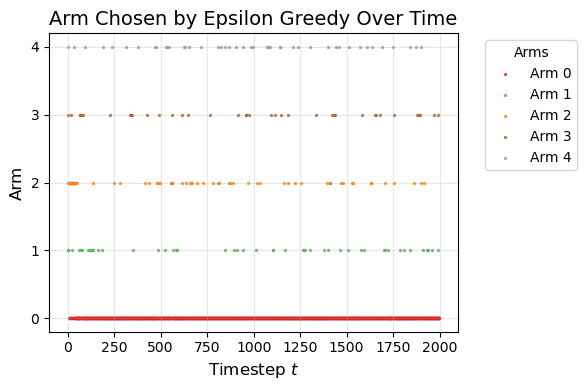

In [15]:
mab = copy.deepcopy(mab_main)
alg = EpsilonGreedy(mab, epsilon = 0.1)
regretls = run_algorithm(mab, alg, R=1)
print(mab.success_probs )
plot_arm_choices(alg.bandit.horizon, alg.bandit.arm_history, 'Epsilon Greedy')

## 5. UCB
Always pick arm with highest upper confidence bound

In [16]:
class UCB:
    def __init__(self, bandit, delta=0.05):
        """
        UCB Algorithm for Multi-Armed Bandit Problem.

        Parameters:
            bandit (BernoulliBandit): The bandit instance to interact with.
            delta (float): Confidence level for UCB bounds.
        """
        self.bandit = bandit
        self.delta = delta

    def reset(self):
        """
        Resets the bandit to its initial state.
        """
        self.bandit.reset()

    def play_one_step(self):
        """
        Plays one step using the UCB algorithm and selects the optimal arm.

        Returns:
            reward (int): The reward obtained from the selected arm.
        """
        pulls = self.bandit.pulls_per_arm()
        rewards = self.bandit.cumulative_rewards()
        T = self.bandit.get_T()
        K = len(pulls)

        # Avoid division by zero using `np.where` and calculate average rewards.
        avg_rewards = np.divide(rewards, pulls, where=pulls != 0)

        # Compute UCB values
        ucb_array = avg_rewards + np.sqrt(np.log((K * T + 1e-7)/ self.delta) / (2*pulls + 1e-7))

        # Break ties randomly when selecting the optimal arm
        best_arms = np.where(ucb_array == np.max(ucb_array))[0]
        if(len(best_arms) == 0):
            best_arms = np.arange(K)
    
        selected_arm = np.random.choice(best_arms)

        # Pull the selected arm
        return self.bandit.pull_arm(selected_arm)

    def get_statistics(self):
        """
        Returns the true means, mean estimates, and upper confidence bounds for each arm.

        Returns:
            stats (dict): A dictionary containing:
                - "true_means" (np.ndarray): True success probabilities of each arm.
                - "mean_estimates" (np.ndarray): Empirical mean estimates of each arm.
                - "ucb" (np.ndarray): Upper confidence bounds for each arm.
        """
        pulls = self.bandit.pulls_per_arm()
        rewards = self.bandit.cumulative_rewards()
        T = self.bandit.get_T()
        K = len(pulls)

        # Calculate mean estimates
        mean_estimates = np.divide(rewards, pulls, where=pulls != 0)

        # Calculate UCB values
        ucb_array = mean_estimates + np.sqrt(np.log((K * T +1e-7)/ self.delta) / (2 * pulls + 1e-7))

        # Get true means (success probabilities)
        true_means = self.bandit.success_probabilities()

        return {
            "true_means": true_means,
            "mean_estimates": mean_estimates,
            "ucb": ucb_array
        }


/var/folders/31/9jkq57lx18sbdhp3w_9lcy140000gn/T/ipykernel_3775/3213293070.py:35: RuntimeWarning: invalid value encountered in sqrt
  ucb_array = avg_rewards + np.sqrt(np.log((K * T + 1e-7)/ self.delta) / (2*pulls + 1e-7))


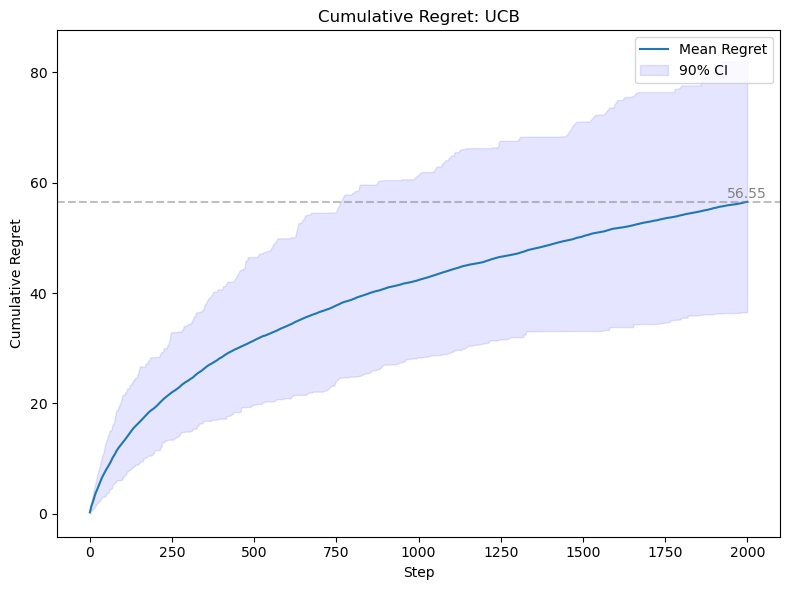

In [17]:
mab = copy.deepcopy(mab_main)
alg = UCB(mab, delta = 0.05)
regretls = run_algorithm(mab, alg, R=100)
plot_regret_single(mab, regretls, 'UCB')

/var/folders/31/9jkq57lx18sbdhp3w_9lcy140000gn/T/ipykernel_3775/3213293070.py:35: RuntimeWarning: invalid value encountered in sqrt
  ucb_array = avg_rewards + np.sqrt(np.log((K * T + 1e-7)/ self.delta) / (2*pulls + 1e-7))


[0.92403512 0.15787058 0.86691508 0.08415694 0.57357368]


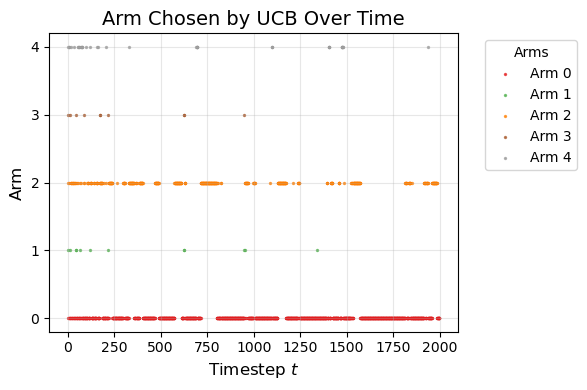

In [18]:
mab = copy.deepcopy(mab_main)
alg = UCB(mab, delta = 0.05)
regretls = run_algorithm(mab, alg, R=1)
print(mab.success_probs )
plot_arm_choices(alg.bandit.horizon, alg.bandit.arm_history, 'UCB')

/var/folders/31/9jkq57lx18sbdhp3w_9lcy140000gn/T/ipykernel_3775/3213293070.py:35: RuntimeWarning: invalid value encountered in sqrt
  ucb_array = avg_rewards + np.sqrt(np.log((K * T + 1e-7)/ self.delta) / (2*pulls + 1e-7))


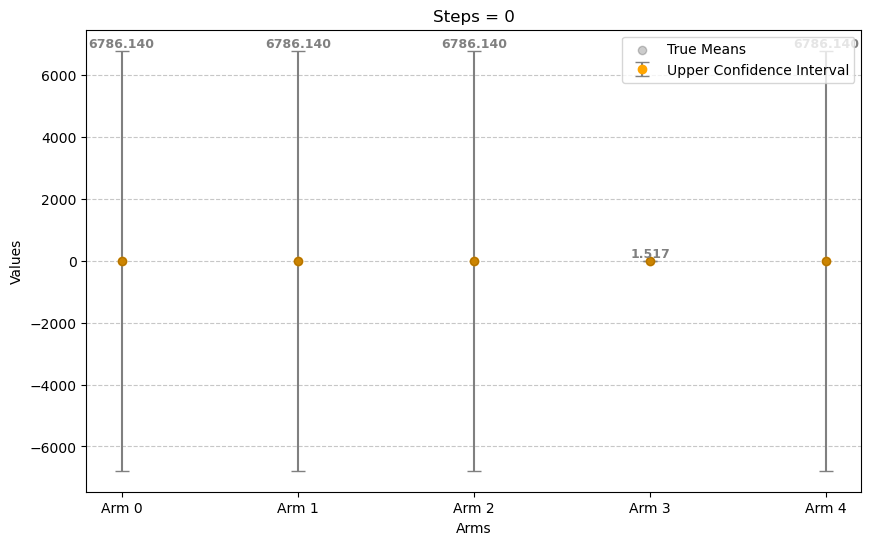

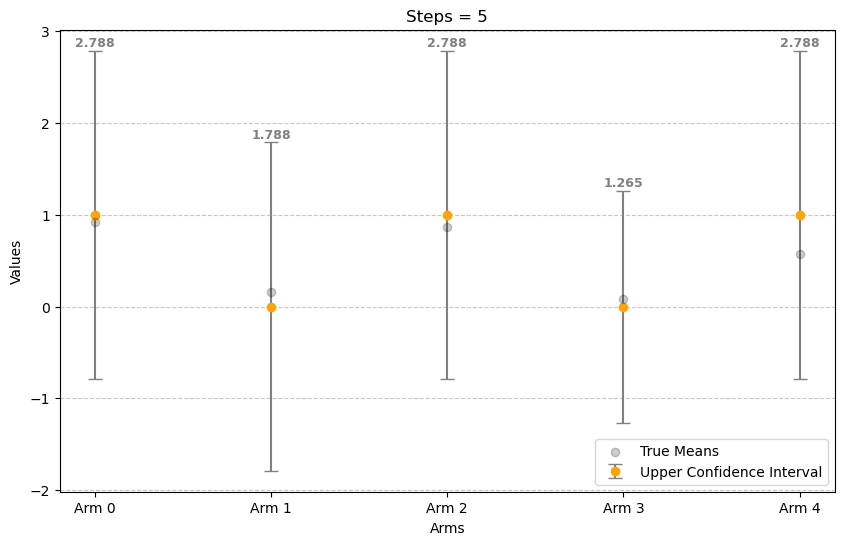

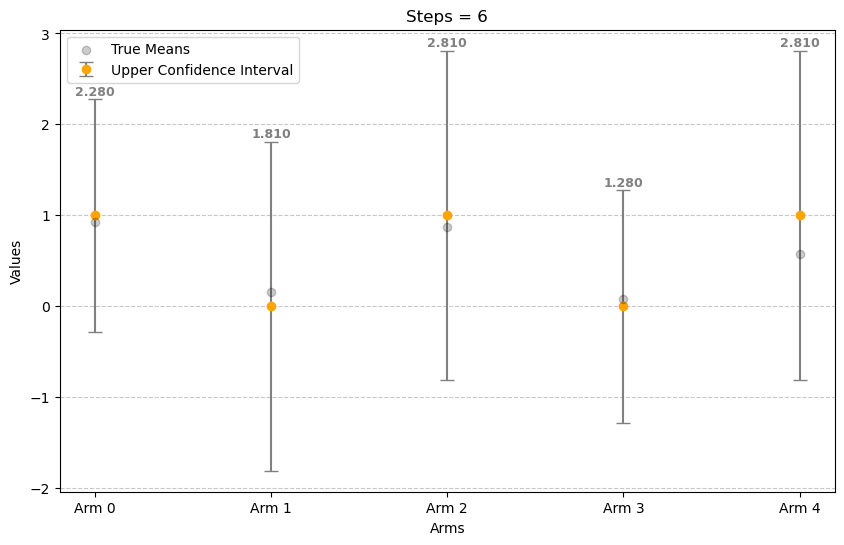

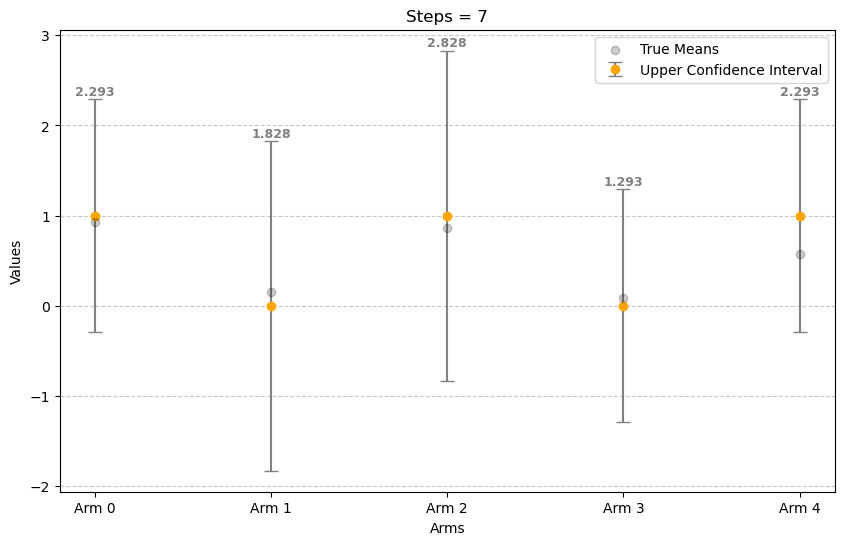

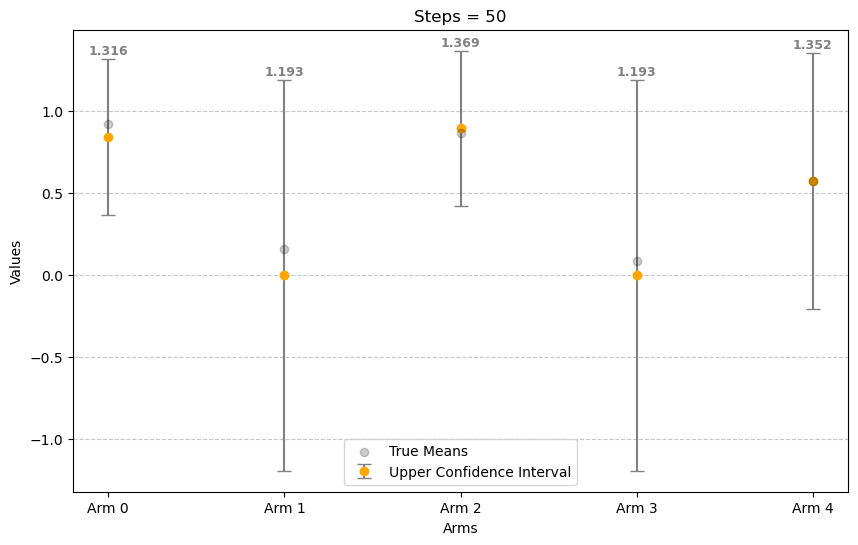

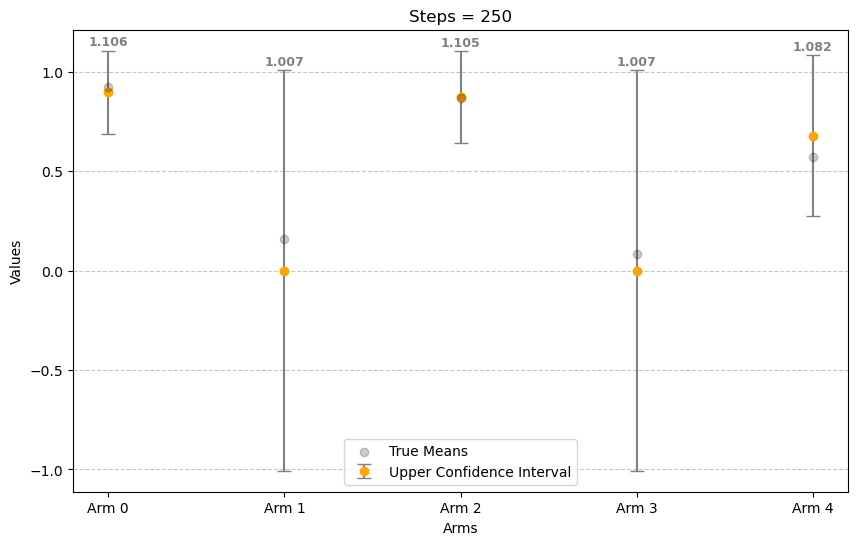

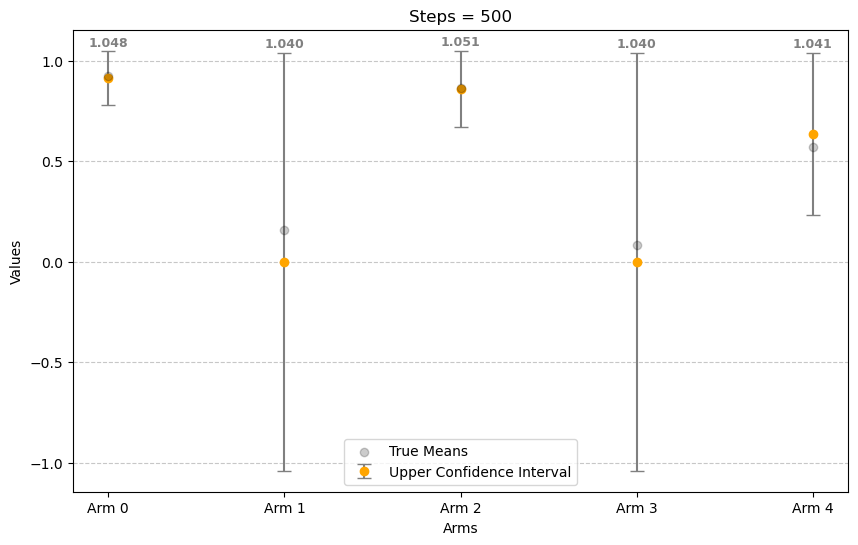

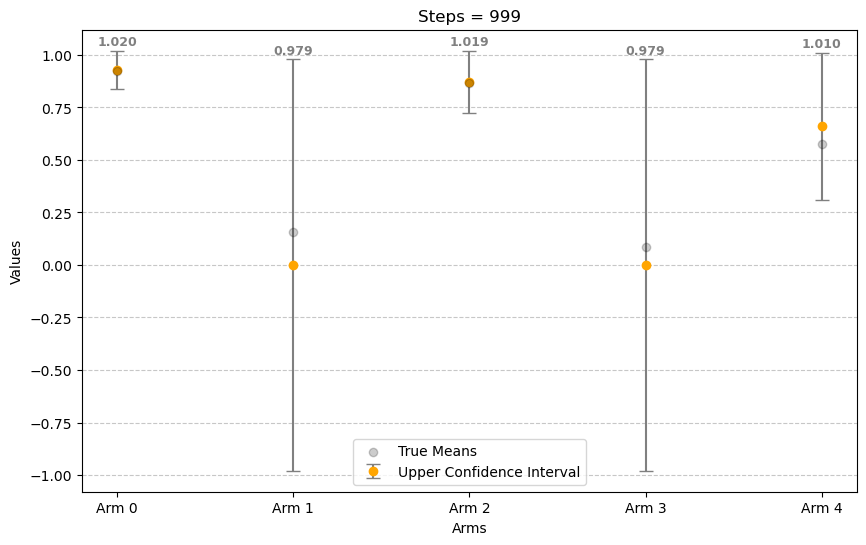

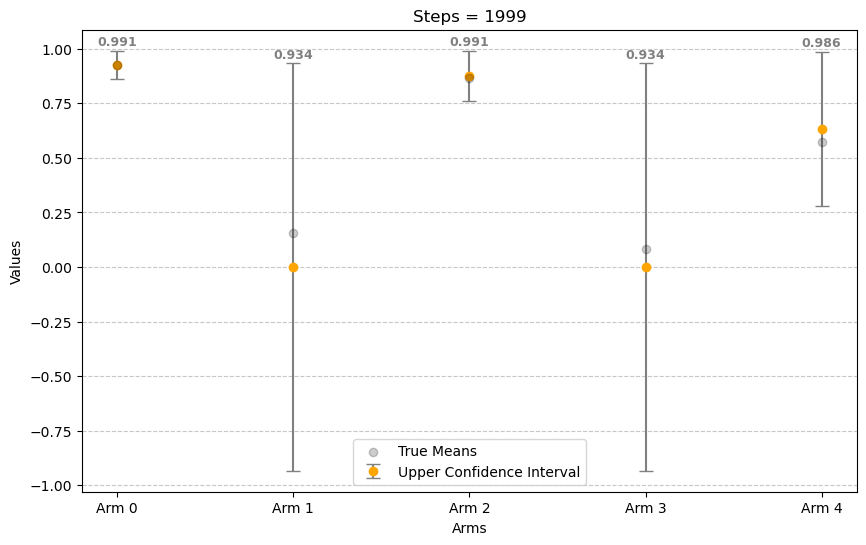

In [19]:
mab = copy.deepcopy(mab_main)
alg = UCB(mab)
for t in range(2000):
    alg.play_one_step()
    if t in [0, 5, 6, 7, 50, 250, 500, 999, 1999]:
        stats = alg.get_statistics()
        plot_ucb(stats, t)
    

## 6. Thompson Sampling
Sampling a value of mean estimate from each arm's posterior distribution of arm reward.
Pick arm with highest sample value.

In [20]:
class ThompsonSampling:
    def __init__(self, bandit, alpha_prior=1.0, beta_prior=1.0):
        """
        Thompson Sampling Strategy for Multi-Armed Bandit with customizable priors.

        Parameters:
            bandit: The BernoulliBandit instance.
            alpha_prior: Scalar, initial prior successes for all arms.
            beta_prior: Scalar, initial prior failures for all arms.
        """
        self.bandit = bandit
        self.num_arms = self.bandit.num_arms
        self.alpha = np.full(self.num_arms, alpha_prior)  # Same prior success for all arms
        self.beta = np.full(self.num_arms, beta_prior)    # Same prior failure for all arms

    def reset(self):
        """
        Resets the bandit and prior distributions.
        """
        self.bandit.reset()
        self.alpha.fill(1.0)  # Reset to default prior success
        self.beta.fill(1.0)   # Reset to default prior failure

    def play_one_step(self):
        """
        Selects an arm using Thompson Sampling:
        - Samples a probability for each arm from its Beta distribution.
        - Pulls the arm with the highest sampled probability.
        """
        # Sample from Beta distribution for each arm
        sampled_probs = np.random.beta(self.alpha, self.beta)
        chosen_arm = np.argmax(sampled_probs)

        # Pull the chosen arm
        reward = self.bandit.pull_arm(chosen_arm)

        # Update the Beta distribution parameters
        if reward == 1:
            self.alpha[chosen_arm] += 1
        else:
            self.beta[chosen_arm] += 1

        return reward

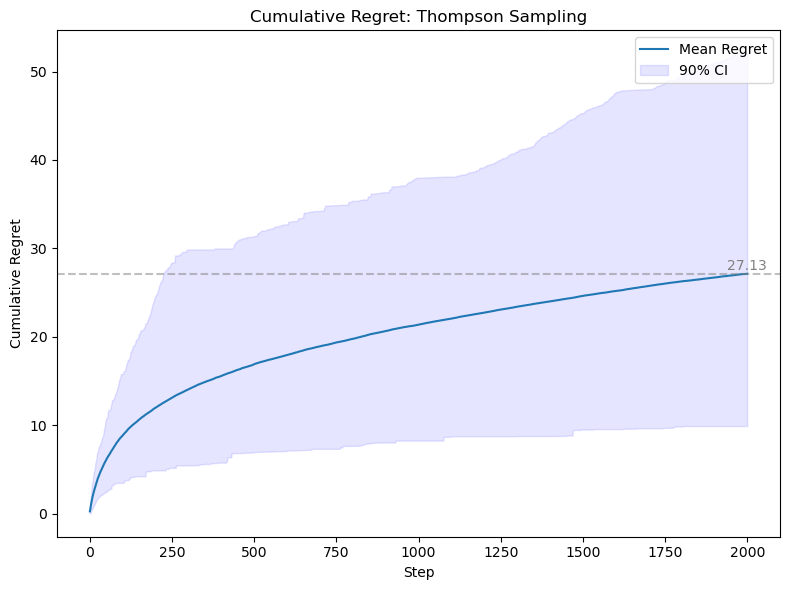

In [21]:
mab = copy.deepcopy(mab_main)
alg = ThompsonSampling(mab)
regretls = run_algorithm(mab, alg, R=100)
plot_regret_single(mab, regretls, 'Thompson Sampling')

Thompson sampling tried arm 1,3, and 4 very few times and can conclude that they are not promising. 

Most of the exploration is focused on checking arm 2 vs arm 0.

Ultimately, it found that arm 0 is better!

[0.92403512 0.15787058 0.86691508 0.08415694 0.57357368]


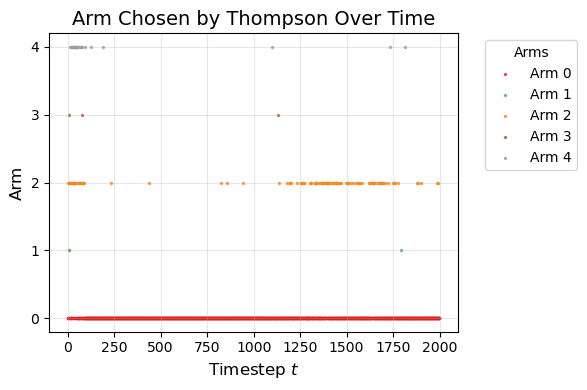

In [22]:
mab = copy.deepcopy(mab_main)
alg = ThompsonSampling(mab)
regretls = run_algorithm(mab, alg, R=1)
print(mab.success_probs )
plot_arm_choices(alg.bandit.horizon, alg.bandit.arm_history, 'Thompson')

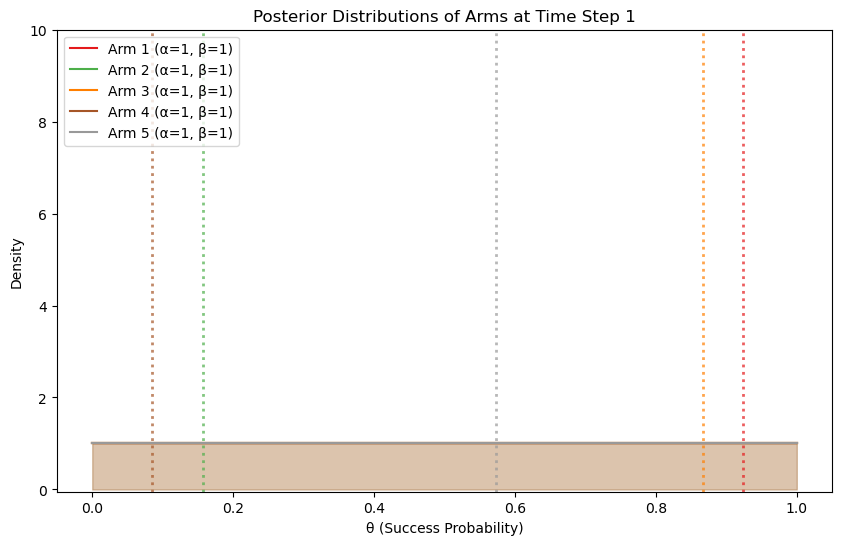

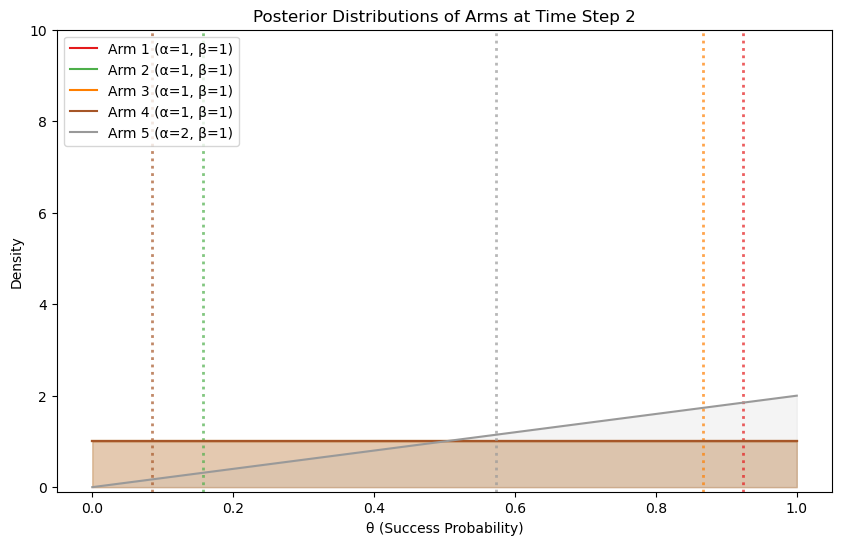

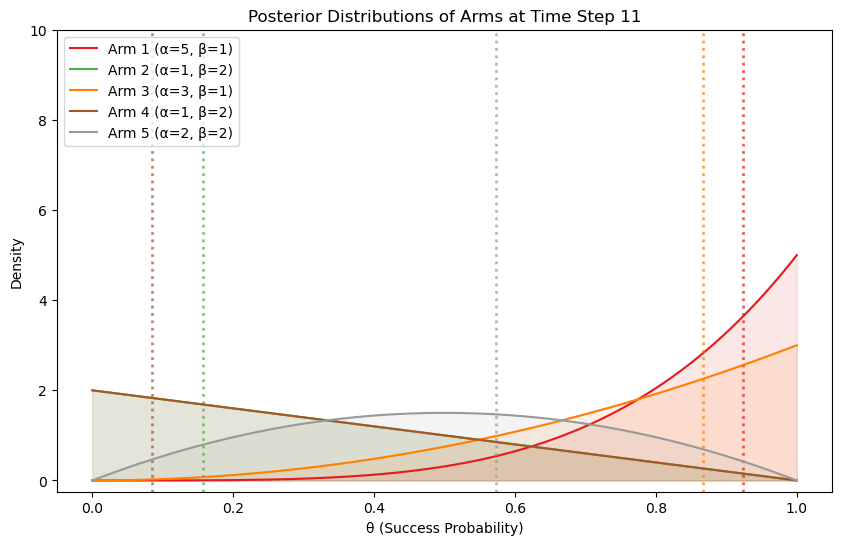

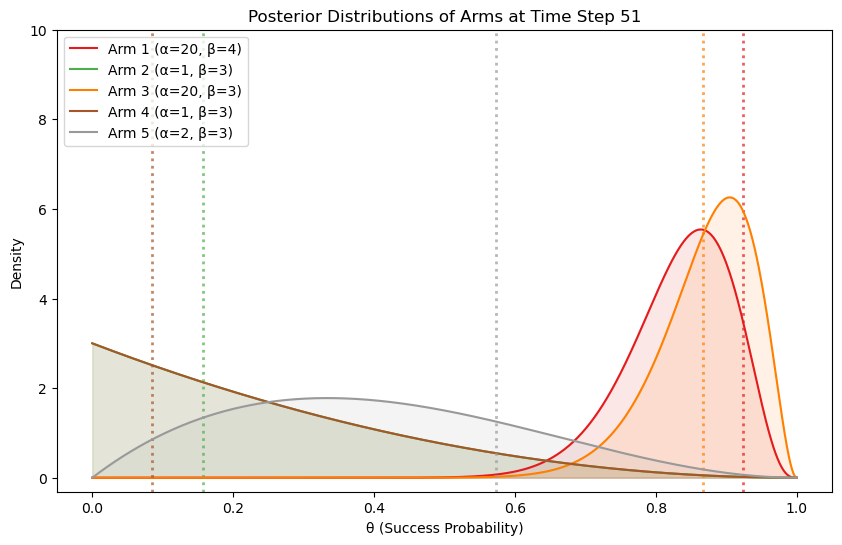

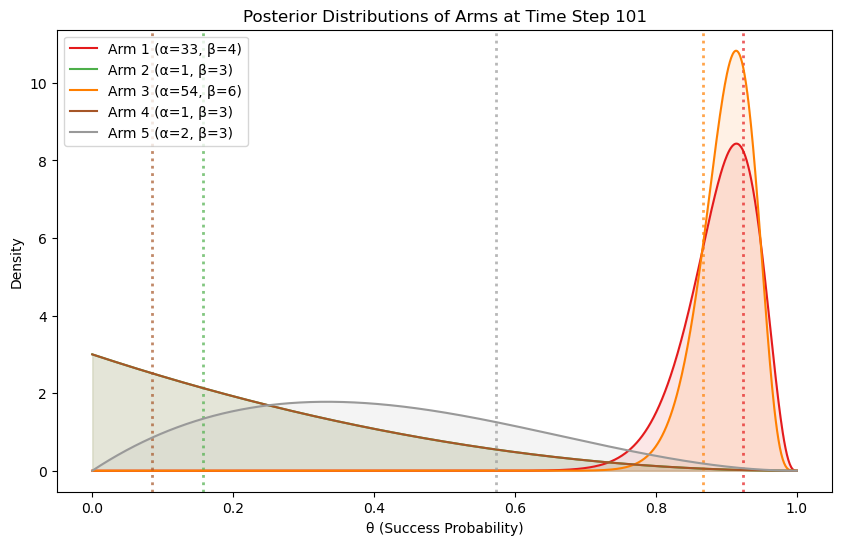

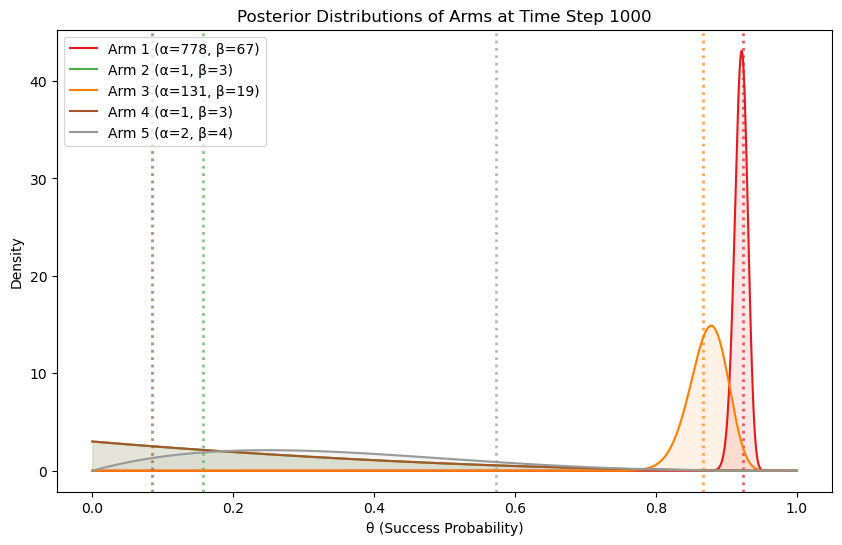

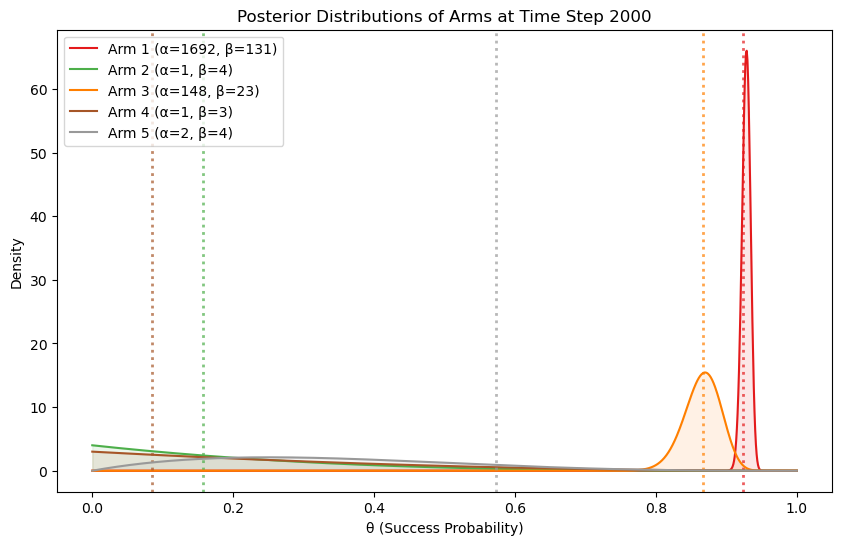

In [23]:
mab = copy.deepcopy(mab_main)
alg = ThompsonSampling(mab, alpha_prior = 1, beta_prior = 1)
for t in range(2000):
    alphas = alg.alpha
    betas = alg.beta
    arm_mean = mab.success_probs
    if(t in [0, 1, 10, 50, 100, 999, 1999]):
        plot_thompson(mab, alphas, betas, t)
    alg.play_one_step()
   

/var/folders/31/9jkq57lx18sbdhp3w_9lcy140000gn/T/ipykernel_3775/3213293070.py:35: RuntimeWarning: invalid value encountered in sqrt
  ucb_array = avg_rewards + np.sqrt(np.log((K * T + 1e-7)/ self.delta) / (2*pulls + 1e-7))


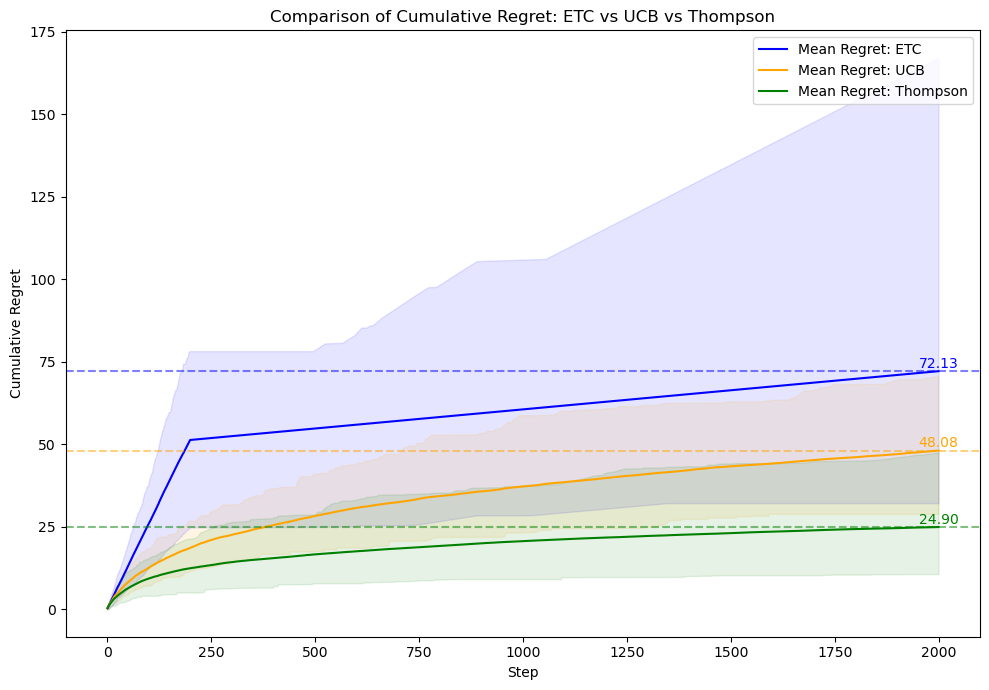

In [24]:
R = 100
mab = copy.deepcopy(mab_main)
mab1 = copy.deepcopy(mab)
alg1 = ExploreThenCommit(mab1, Ne = 40)
regretls1 = run_algorithm(mab1, alg1, R=R)

mab2 = copy.deepcopy(mab)
alg2 = UCB(mab2, delta = 0.2)
regretls2 = run_algorithm(mab2, alg2, R=R)

mab3 = copy.deepcopy(mab)
alg3 = ThompsonSampling(mab3, alpha_prior = 1, beta_prior = 1)
regretls3 = run_algorithm(mab3, alg3, R=R)

plot_regret_triple(mab, regretls1, regretls2, regretls3, 'ETC', 'UCB', 'Thompson')

In [25]:
for i in range(100):
    random.seed(i)
    np.random.seed(i)
    mab_main = BernoulliBandit(horizon=2000, num_arms=5, prob_min=0, prob_max=1)
    p = mab_main.success_probs
    if np.sort(p)[-1]- np.sort(p)[-2] <0.07 and np.sort(p)[-1]- np.sort(p)[-2] > 0.03 and np.max(p)>0.8:
        print(i)
        print(p)


5
[0.22199317 0.87073231 0.20671916 0.91861091 0.48841119]
24
[0.9600173  0.69951205 0.99986729 0.2200673  0.36105635]
27
[0.42572141 0.81458374 0.73539729 0.8680032  0.38338077]
49
[0.30096446 0.24706183 0.92633514 0.89160344 0.68327676]
59
[0.92403512 0.15787058 0.86691508 0.08415694 0.57357368]
75
[0.56894022 0.06596423 0.88811067 0.92965818 0.67969204]
83
[0.25704243 0.68378758 0.66364176 0.77713043 0.82736663]
